Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

**Importing Skin Cancer Data**
Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from glob import glob

In [3]:
#mounting the google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/My Drive/Colab Notebooks/Train")
data_dir_test = pathlib.Path("/content/gdrive/My Drive/Colab Notebooks/Test/")

In [5]:
#Number of images in Train and Test
image_count_train = len(list(data_dir_train.glob('*/*.jpg*')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


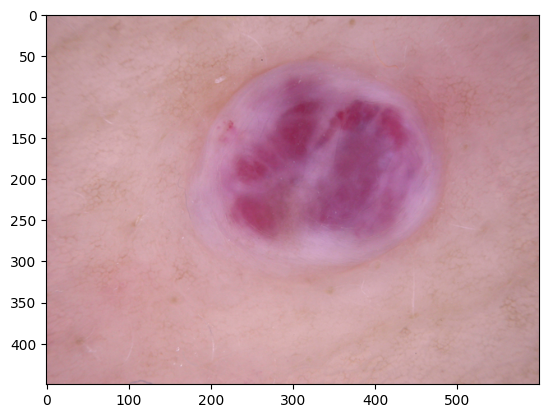

In [6]:
#read 1 image
img=mpimg.imread( str(data_dir_train) + '/vascular lesion/ISIC_0033349.jpg')
imgplot = plt.imshow(img)

**Load using keras.preprocessing**

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# **Visualize the data**

**create a code to visualize one instance of all the nine classes present in the dataset**

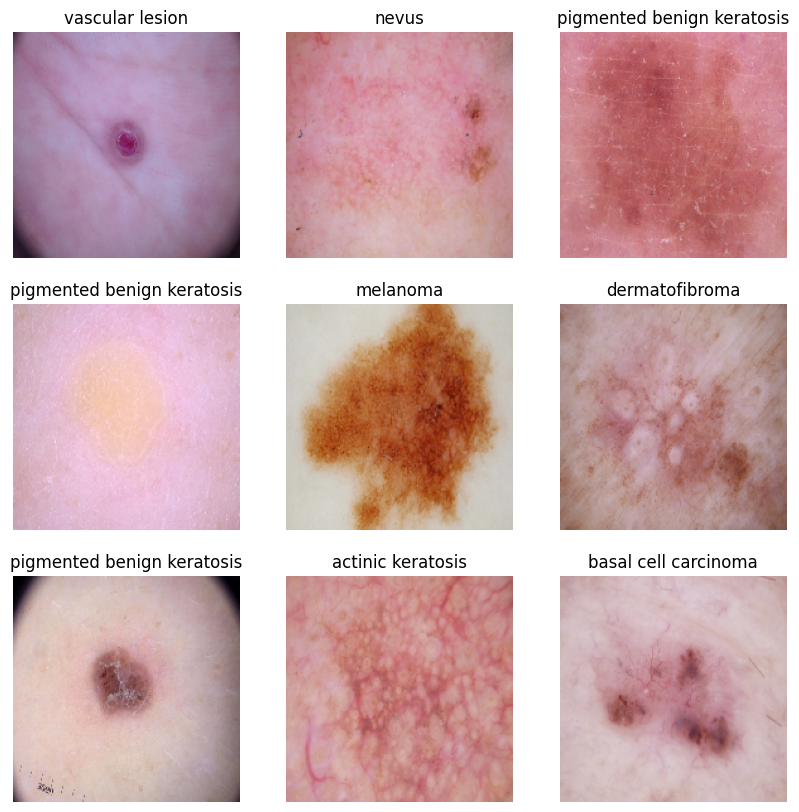

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.



In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Create the model

** Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]**

In [13]:
### Your code goes here
model = Sequential()
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width,3)))
#1st block
model.add(Conv2D(filters=16, kernel_size=(3,3),padding='Same',activation='relu'))
model.add(Conv2D(filters=16, kernel_size=(3,3),padding ='Same',activation='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))

#2nd block
model.add(Conv2D(filters=32, kernel_size=(3,3),padding ='Same',activation='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))

#3rd block
model.add(Conv2D(filters=64, kernel_size=(3,3),padding ='Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))

#4th block
model.add(Conv2D(filters=128, kernel_size=(3,3),padding ='Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))

#5th block
model.add(Conv2D(filters=256, kernel_size=(3,3),padding ='Same',activation='relu'))
model.add(MaxPool2D(pool_size = (2,2)))

#Dense layer
model.add(Flatten())
model.add(Dense(units=256,activation='relu'))
model.add(Dense(units=9,activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                   

### Train the model

In [16]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 430s 2s/step - loss: 2.0548 - accuracy: 0.1970 - val_loss: 1.9595 - val_accuracy: 0.2394
Epoch 2/20
56/56 [==============================] - 2s 36ms/step - loss: 1.8878 - accuracy: 0.2902 - val_loss: 1.8072 - val_accuracy: 0.2819
Epoch 3/20
56/56 [==============================] - 2s 34ms/step - loss: 1.7599 - accuracy: 0.3454 - val_loss: 1.6919 - val_accuracy: 0.3714
Epoch 4/20
56/56 [==============================] - 2s 35ms/step - loss: 1.7137 - accuracy: 0.3616 - val_loss: 1.6287 - val_accuracy: 0.3915
Epoch 5/20
56/56 [==============================] - 2s 34ms/step - loss: 1.6274 - accuracy: 0.4023 - val_loss: 1.5840 - val_accuracy: 0.4206
Epoch 6/20
56/56 [==============================] - 2s 36ms/step - loss: 1.5593 - accuracy: 0.4392 - val_loss: 1.6037 - val_accuracy: 0.4295
Epoch 7/20
56/56 [==============================] - 2s 35ms/step - loss: 1.5104 - accuracy: 0.4621 - val_loss: 1.5639 - val_accuracy: 0.4183
Epoch 8/20
56/56 [======

### Visualizing training results

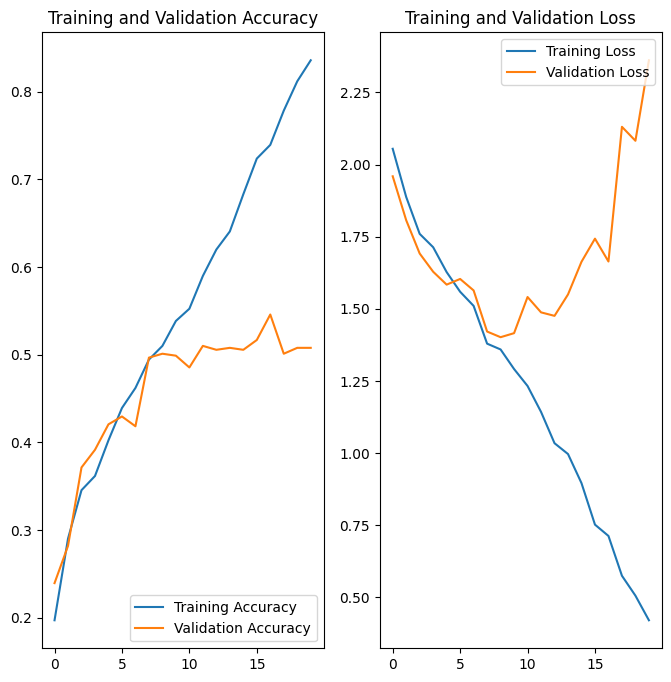

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####Write your findings after the model fit, see if there is an evidence of model overfit or underfit

** Write your findings here**
1. Training Accuracy > 80%, validation accuracy ~50%.
2. Looks like model is overfitting
3. Loss on training gradually decreasing. But loss on validation fluctuates

# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here

In [18]:
data_augmentation = tf.keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

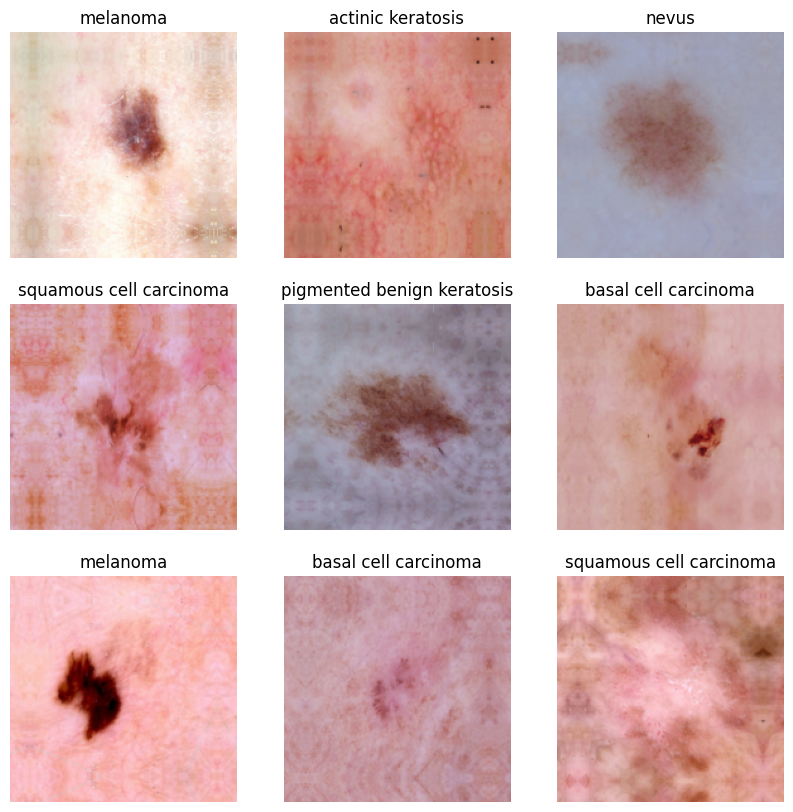

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(data_augmentation(images)[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Todo:
### Create the model, compile and train the model

## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

In [19]:
model = Sequential()
model.add(data_augmentation)
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))

#1st block
model.add(Conv2D(filters=16, kernel_size=(3,3),padding='Same',activation='relu'))
model.add(Conv2D(filters=16, kernel_size=(3,3),padding ='Same',activation='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

#2nd block
model.add(Conv2D(filters=32, kernel_size=(3,3),padding ='Same',activation='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

#3rd block
model.add(Conv2D(filters=64, kernel_size=(3,3),padding ='Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

#4th block
model.add(Conv2D(filters=128, kernel_size=(3,3),padding ='Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

#5th block
model.add(Conv2D(filters=256, kernel_size=(3,3),padding ='Same',activation='relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#Dense layer
model.add(Flatten())
model.add(Dense(units=256,activation='relu'))
model.add(Dense(units=9,activation='softmax'))


### Compiling the model

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_22 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_21 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_193 (Conv2D)         (None, 180, 180, 16)      448       
                                                                 
 conv2d_194 (Conv2D)         (None, 180, 180, 16)      2320      
                                                                 
 max_pooling2d_104 (MaxPool  (None, 90, 90, 16)        0         
 ing2D)                                                          
                                                                 
 dropout_21 (Dropout)        (None, 90, 90, 16)        0         
                                                     

In [21]:
### Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 8s 54ms/step - loss: 2.0559 - accuracy: 0.1853 - val_loss: 2.0771 - val_accuracy: 0.1879
Epoch 2/20
56/56 [==============================] - 3s 51ms/step - loss: 2.0019 - accuracy: 0.2221 - val_loss: 1.9296 - val_accuracy: 0.2953
Epoch 3/20
56/56 [==============================] - 3s 50ms/step - loss: 1.8697 - accuracy: 0.3008 - val_loss: 1.7330 - val_accuracy: 0.3400
Epoch 4/20
56/56 [==============================] - 3s 52ms/step - loss: 1.7728 - accuracy: 0.3438 - val_loss: 1.6656 - val_accuracy: 0.3758
Epoch 5/20
56/56 [==============================] - 3s 53ms/step - loss: 1.6448 - accuracy: 0.3929 - val_loss: 1.6026 - val_accuracy: 0.4004
Epoch 6/20
56/56 [==============================] - 3s 55ms/step - loss: 1.6013 - accuracy: 0.4219 - val_loss: 1.5673 - val_accuracy: 0.4407
Epoch 7/20
56/56 [==============================] - 3s 50ms/step - loss: 1.5362 - accuracy: 0.4576 - val_loss: 1.7465 - val_accuracy: 0.3647
Epoch 8/20
56

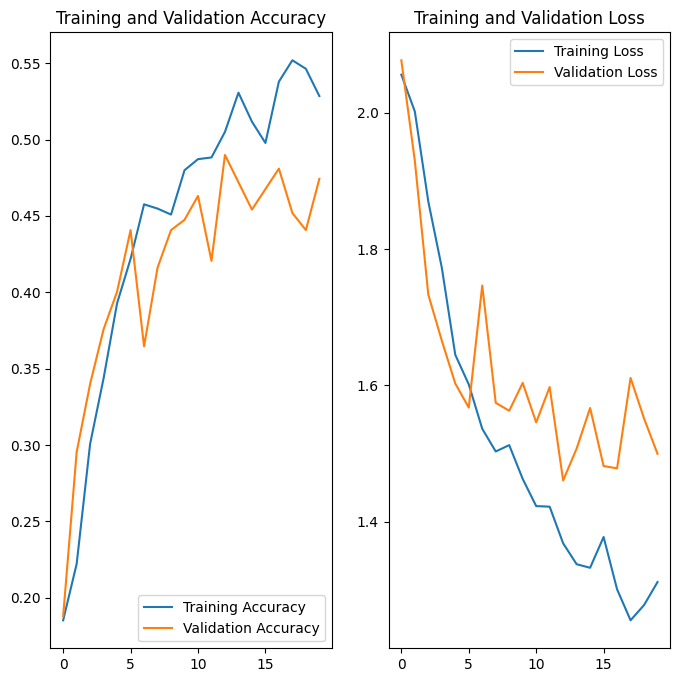

In [22]:
### Visualizing the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit.
1. The training and validation accuracy is almost identical ~50%.
2. So model is not overfitting.
3. however- accuracy is still low - can be improved - may be more epochs(not tried as taking too long to execute)

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [23]:
# Different images in each class
class_images=pd.DataFrame()
for i in range(len(class_names)):
  count = len(list(data_dir_train.glob(f'{class_names[i]}/*.jpg')))
  class_images=class_images.append({'class':class_names[i],'count':count},ignore_index=True)

class_images

<ipython-input-23-22a240d7a524>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_images=class_images.append({'class':class_names[i],'count':count},ignore_index=True)
<ipython-input-23-22a240d7a524>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_images=class_images.append({'class':class_names[i],'count':count},ignore_index=True)
<ipython-input-23-22a240d7a524>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_images=class_images.append({'class':class_names[i],'count':count},ignore_index=True)
<ipython-input-23-22a240d7a524>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_images=class_images.append({'class':class

,class,count
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


<function matplotlib.pyplot.show(close=None, block=None)>

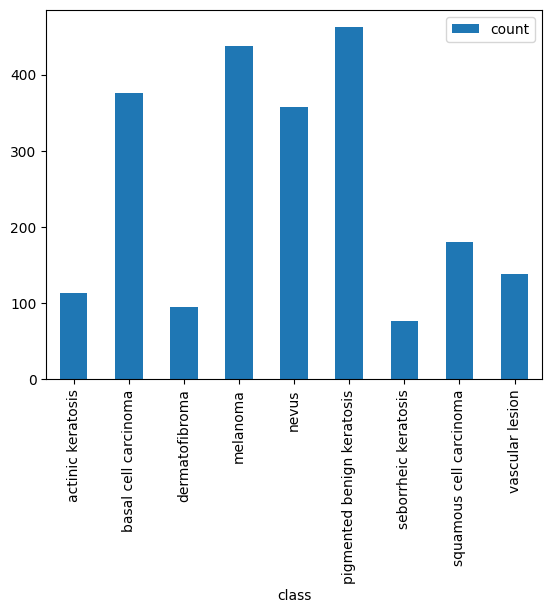

In [24]:
#plot the classes
class_images.plot.bar(x='class',y='count')
plt.show

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?
seborrheic keratosis has least number of samples(77)
pigmented benign keratosis has the highest number of samples(462)

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [25]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.

In [26]:
path_to_training_dataset="/content/gdrive/My Drive/Colab Notebooks/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C88A19BE380>: 100%|██████████| 500/500 [00:20<00:00, 23.92 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C88A073A800>: 100%|██████████| 500/500 [00:23<00:00, 21.65 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C88A19A14E0>: 100%|██████████| 500/500 [00:20<00:00, 24.86 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7C88A1B7A380>: 100%|██████████| 500/500 [01:39<00:00,  5.02 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7C88A0732260>: 100%|██████████| 500/500 [01:18<00:00,  6.37 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C88A0794760>: 100%|██████████| 500/500 [00:17<00:00, 28.05 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7C88A19A14E0>: 100%|██████████| 500/500 [00:40<00:00, 12.49 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C88B443E470>: 100%|██████████| 500/500 [00:17<00:00, 29.16 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C88A0795390>: 100%|██████████| 500/500 [00:18<00:00, 27.27 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [27]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [28]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/My Drive/Colab Notebooks/Train/vascular lesion/output/vascular lesion_original_ISIC_0028406.jpg_7fee1dd2-1770-458a-8ab8-9c7962c05fe5.jpg',
 '/content/gdrive/My Drive/Colab Notebooks/Train/vascular lesion/output/vascular lesion_original_ISIC_0028431.jpg_a8eb14fa-9f4d-492a-a469-3c58fbcdb52c.jpg',
 '/content/gdrive/My Drive/Colab Notebooks/Train/vascular lesion/output/vascular lesion_original_ISIC_0025452.jpg_39bf37fd-11a9-4367-a946-a7be9bffca4e.jpg',
 '/content/gdrive/My Drive/Colab Notebooks/Train/vascular lesion/output/vascular lesion_original_ISIC_0033031.jpg_a0a938cf-a837-4daf-99ec-de9458435716.jpg',
 '/content/gdrive/My Drive/Colab Notebooks/Train/vascular lesion/output/vascular lesion_original_ISIC_0027672.jpg_4c4865b2-7a10-467d-ac30-99439d5fb167.jpg',
 '/content/gdrive/My Drive/Colab Notebooks/Train/vascular lesion/output/vascular lesion_original_ISIC_0026393.jpg_3ebc4964-df85-4a0a-9fa4-4855249a579c.jpg',
 '/content/gdrive/My Drive/Colab Notebooks/Train/vascular 

In [29]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',


In [30]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [31]:
new_df = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df

,Path,Label
0,/content/gdrive/My Drive/Colab Notebooks/Train...,vascular lesion
1,/content/gdrive/My Drive/Colab Notebooks/Train...,vascular lesion
2,/content/gdrive/My Drive/Colab Notebooks/Train...,vascular lesion
3,/content/gdrive/My Drive/Colab Notebooks/Train...,vascular lesion
4,/content/gdrive/My Drive/Colab Notebooks/Train...,vascular lesion
...,...,...
4495,/content/gdrive/My Drive/Colab Notebooks/Train...,melanoma
4496,/content/gdrive/My Drive/Colab Notebooks/Train...,melanoma
4497,/content/gdrive/My Drive/Colab Notebooks/Train...,melanoma
4498,/content/gdrive/My Drive/Colab Notebooks/Train...,melanoma


In [32]:
new_df['Label'].value_counts()

vascular lesion               500
actinic keratosis             500
squamous cell carcinoma       500
basal cell carcinoma          500
seborrheic keratosis          500
nevus                         500
dermatofibroma                500
pigmented benign keratosis    500
melanoma                      500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [33]:
batch_size = 32
img_height = 180
img_width = 180

In [34]:
#### **Todo:** Create a training dataset
data_dir_train="/content/gdrive/My Drive/Colab Notebooks/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [35]:
# **Todo:** Create a validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [36]:
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))

#1st block
model.add(Conv2D(filters=16, kernel_size=(3,3),padding='Same',activation='relu'))
model.add(Conv2D(filters=16, kernel_size=(3,3),padding ='Same',activation='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

#2nd block
model.add(Conv2D(filters=32, kernel_size=(3,3),padding ='Same',activation='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

#3rd block
model.add(Conv2D(filters=64, kernel_size=(3,3),padding ='Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

#4th block
model.add(Conv2D(filters=128, kernel_size=(3,3),padding ='Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

#5th block
model.add(Conv2D(filters=256, kernel_size=(3,3),padding ='Same',activation='relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#Dense layer
model.add(Flatten())
model.add(Dense(units=256,activation='relu'))
model.add(Dense(units=9,activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [37]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [38]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 [==============================] - 49s 263ms/step - loss: 2.0666 - accuracy: 0.1929 - val_loss: 1.9576 - val_accuracy: 0.2606
Epoch 2/30
169/169 [==============================] - 41s 235ms/step - loss: 1.6925 - accuracy: 0.3362 - val_loss: 1.5983 - val_accuracy: 0.3912
Epoch 3/30
169/169 [==============================] - 41s 238ms/step - loss: 1.5034 - accuracy: 0.4097 - val_loss: 1.5216 - val_accuracy: 0.4016
Epoch 4/30
169/169 [==============================] - 43s 247ms/step - loss: 1.4149 - accuracy: 0.4470 - val_loss: 1.6725 - val_accuracy: 0.3764
Epoch 5/30
169/169 [==============================] - 42s 242ms/step - loss: 1.2918 - accuracy: 0.4994 - val_loss: 1.6395 - val_accuracy: 0.3705
Epoch 6/30
169/169 [==============================] - 44s 254ms/step - loss: 1.2528 - accuracy: 0.5130 - val_loss: 1.4065 - val_accuracy: 0.4729
Epoch 7/30
169/169 [==============================] - 42s 244ms/step - loss: 1.1439 - accuracy: 0.5534 - val_loss: 1.2449 - val_accuracy: 0.5

#### **Todo:**  Visualize the model results

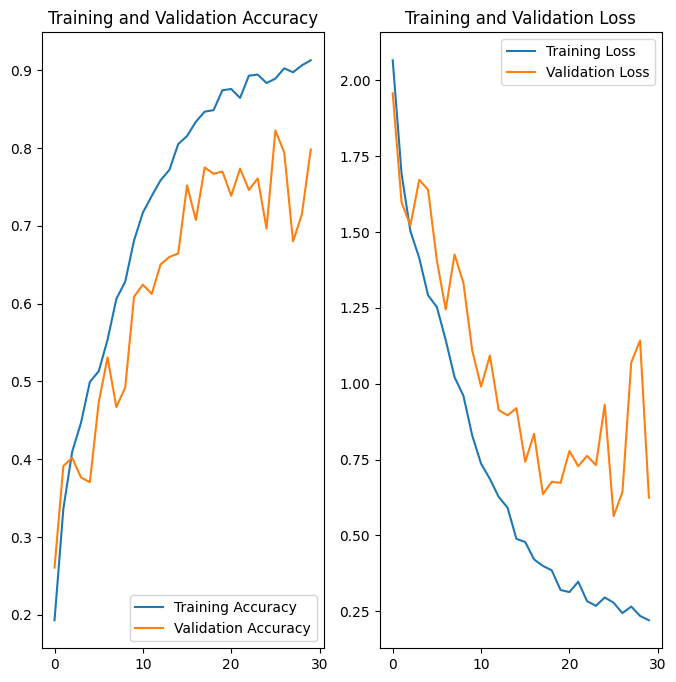

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

Yes-> Class rebalance helped improve accuracy.
However there is still some overfitting
unable to re-build further models due to lack of resources